Epoch 1/300
32/32 [==============================] - 2s 7ms/step - loss: 0.1080
Epoch 2/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0388
Epoch 3/300
32/32 [==============================] - 0s 8ms/step - loss: 0.0212
Epoch 4/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 5/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 6/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0148
Epoch 7/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0140
Epoch 8/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 9/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 10/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 11/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 12/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 13/300
32/32 [=================

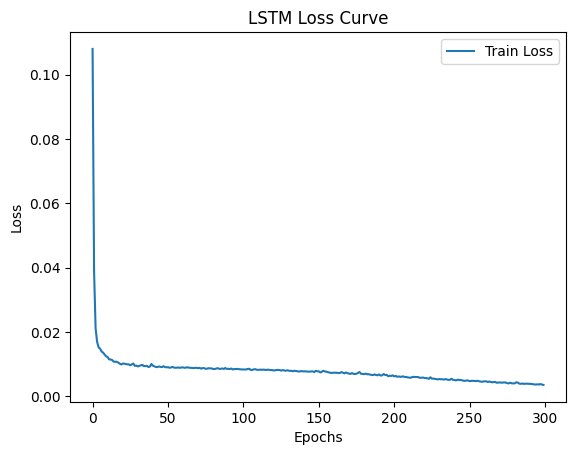

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 283ms/step
Predictions saved to predicted_data.csv at index 1016
Epoch 1/300
32/32 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 2/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 3/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 4/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 5/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 6/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 7/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 8/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 9/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 10/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 11/300
32/32 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 12/30

KeyboardInterrupt: 

In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the datasets
weather_data = pd.read_csv('solar_weather_data.csv')
madeup_data = pd.read_csv('solar_madeupdata.csv')
pred=pd.read_csv('daily_pred.csv')

# Convert 'datetime' column, inferring format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], errors='coerce', dayfirst=True)
madeup_data['datetime'] = pd.to_datetime(madeup_data['datetime'], errors='coerce', dayfirst=True)

# Normalize the data using MinMaxScaler
scaler1 = MinMaxScaler()
scaled_weather_data = scaler1.fit_transform(weather_data[['temp', 'humidity', 'windspeed', 'cloudcover', 'solar_radiation', 'solar_energy', 'uv_index']])

scaler2 = MinMaxScaler()
scaled_madeup_data = scaler2.fit_transform(madeup_data[['ac_power_output_kW']])

# Prepare sequences for Model 1 (LSTM)
def create_sequences(data, time_steps=24):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Create sequences for Model 1
time_steps = 24
X1, y1 = create_sequences(scaled_weather_data, time_steps)

# Split into training set (first 1000 points)
X1_train = X1[:1000]
y1_train = y1[:1000]

# Build Model 1 (LSTM)
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7))  # 7 outputs for temp, humidity, windspeed, cloudcover, solar_radiation, solar_energy, uv_index
    model.compile(optimizer='adam', loss='mse')
    return model

model1 = build_lstm_model((X1_train.shape[1], X1_train.shape[2]))
history = model1.fit(X1_train, y1_train, epochs=300, batch_size=32,verbose=1)

# Plot the loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.title('LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train Model 2 (RandomForest) using real data
# Combine the 7 weather features as input for Model 2 and solar power output as the target
model2_input = weather_data[['temp', 'humidity', 'windspeed', 'cloudcover', 'solar_radiation', 'solar_energy', 'uv_index']]
model2_output = madeup_data['ac_power_output_kW']

# Normalize the inputs for Model 2
scaled_model2_input = scaler1.transform(model2_input)
scaled_model2_output = scaler2.transform(model2_output.values.reshape(-1, 1))

# Train RandomForest for solar power output prediction
model2 = RandomForestRegressor(n_estimators=100)
model2.fit(scaled_model2_input[:1016], scaled_model2_output[:1016].ravel())


# Incremental prediction and retraining
index = 16
interval = 1  # Resting time in seconds

while index + 24 <= len(X1)-1000:
    # Predict next 24 data points using Model 1 (LSTM)
    X1_next = X1[index+1000:index + 1024]
    y1_pred = model1.predict(X1_next)

    # Inverse transform Model 1's predictions (weather features)
    weather_predictions=scaler1.inverse_transform(y1_pred)

    # Use Model 1's predictions (7 features) as inputs for Model 2 (RandomForest)
    # Predict solar power generation for the next 24 timesteps using Model 2
    y2_pred = model2.predict(y1_pred)

    solar_predictions=scaler2.inverse_transform(y2_pred.reshape(-1, 1))

    # Combine both predictions (Weather + Solar Output) into a DataFrame
    predictions_df = pd.DataFrame({
        'datetime': weather_data['datetime'][index + 1000:index + 1024],
        'pred_temp': weather_predictions[:, 0],
        'pred_humidity': weather_predictions[:, 1],
        'pred_windspeed': weather_predictions[:, 2],
        'pred_cloudcover': weather_predictions[:, 3],
        'pred_solar_radiation': weather_predictions[:, 4],
        'pred_solar_energy': weather_predictions[:, 5],
        'pred_uv_index': weather_predictions[:, 6],
        'pred_ac_power_output_kW': solar_predictions.flatten()
    })

    # Save the predictions to a CSV file (overwrite after each iteration)
    predictions_df.to_csv('weather_solar_pred.csv', index=False)
    pred_df = pd.DataFrame({
        'datetime': weather_data['datetime'][index + 1000:index + 1024],
        'pred_temp': weather_predictions[:, 0],
        'pred_humidity': weather_predictions[:, 1],
        'pred_windspeed': weather_predictions[:, 2],
        'pred_cloudcover': weather_predictions[:, 3],
        'pred_solar_radiation': weather_predictions[:, 4],
        'pred_solar_energy': weather_predictions[:, 5],
        'pred_uv_index': weather_predictions[:, 6],
        'pred_solar_output_kW': solar_predictions.flatten()
    })
    pred_df.to_csv('daily_pred.csv',index=False)
    print(f"Predictions saved to predicted_data.csv at index {index + 1000}")

    # Simulate waiting for a specified time
    time.sleep(interval)

    # Append the real data from both datasets and retrain both models
    index+=24
    X1_train=X1[index:index+1016]
    y1_train=y1[index:index+1016]

    # Retrain Model 1 (LSTM)
    model1.fit(X1_train, y1_train, epochs=300, batch_size=32,verbose=1)

    # Append the real data for Model 2
    model2_new_input = scaled_model2_input[index:index + 1000]
    model2_new_output = scaled_model2_output[index:index + 1000]
    
    # Retrain Model 2 (RandomForest)
    model2.fit(np.concatenate([scaled_model2_input[:index+1000], model2_new_input]),
               np.concatenate([scaled_model2_output[:index+1000], model2_new_output]).ravel())